## Data-wrangling

In [1]:
# Set up environment

import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Read in our data

tweets_df = pd.read_csv("https://raw.githubusercontent.com/luke-swans0n/DonaldTrumpSPX/main/Data/tweets_01-08-2021.csv")
spx_df = pd.read_csv("https://raw.githubusercontent.com/luke-swans0n/DonaldTrumpSPX/main/Data/HistoricalPricesSPX.csv")
#format the date columns so they match-up.
spx_df['Date'] = pd.to_datetime(spx_df.Date)
spx_df.columns = [x.lower() for x in list(spx_df.columns)]
tweets_df['date'] = pd.to_datetime(tweets_df.date)
tweets_df['date'] = tweets_df['date'].dt.strftime('%m/%d/%Y')
tweets_df['date'] = pd.to_datetime(tweets_df.date)

Our data comes from two sources. A complete repository of Donald Trump's tweets are available online at [The Trump Archive](https://www.thetrumparchive.com/) for the sake of this experiment, we are interested only in the tweets posted after election day 2016. The [historical data for SPX](https://www.wsj.com/market-data/quotes/index/SPX/historical-prices) is courtesy of *The Wall Street Journal*. We are considering only days from election day 2016 up to the day after Twitter banned the President.

In [2]:
#quick look at the tweet data.
tweets_df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f


In [3]:
#quick look at SPX data
spx_df.head()

,date,open,high,low,close
0,2021-01-12,3801.62,3810.78,3776.51,3801.19
1,2021-01-11,3803.14,3817.86,3789.02,3799.61
2,2021-01-08,3815.05,3826.69,3783.60,3824.68
3,2021-01-07,3764.71,3811.55,3764.71,3803.79
4,2021-01-06,3712.20,3783.04,3705.34,3748.14


In [4]:
tweets_no_retweet = tweets_df[tweets_df.isRetweet == 'f']

Retweets are not being considered because they are generally (except when he retweets himself) written by other people, and we are more interested in how the President's words move markets. 

In [5]:
tweets_no_retweet_no_link = tweets_no_retweet[~tweets_no_retweet.text.str.contains('http')]

For the same reason we are not considering retweets, we are also ignoring tweets that contain a link to another website. So, after excluding retweets and links to somewhere else, we are left with only what can be assumed to be Donald Trump's original thoughts he wants the American people to hear.

In [6]:
#define volatiltiy column
spx_df['diff'] = spx_df[' high'] - spx_df[' low']

Here, we're defining our variable of interest. There are a variety of different ways to evaluate volatility: from the CBOE's Vix volatility index to solving for Implied Volatility in the Black-Scholes model. The Vix is not normally distributed. THere is also a notable difference in realized volatility (the actual volatility in the underlying of an option) and the implied volatility. IV also changes continuously during the trading day and into the evening while high-low is set after market close. By definition, increased volatility in the market implies that prices are changing by larger magnitudes and thus widening the spread of SPX's daily high-low. 

In [7]:
#combine data frames.
market_tweets = spx_df.merge(tweets_no_retweet_no_link, how='left', on='date' )
market_tweets.head()

,date,open,high,low,close,diff,id,text,isRetweet,isDeleted,device,favorites,retweets,isFlagged
0,2021-01-12,3801.62,3810.78,3776.51,3801.19,34.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-11,3803.14,3817.86,3789.02,3799.61,28.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-08,3815.05,3826.69,3783.60,3824.68,43.09,1.347555e+18,"The 75,000,000 great American Patriots who vot...",f,f,Twitter for iPhone,480997.0,108844.0,f
3,2021-01-08,3815.05,3826.69,3783.60,3824.68,43.09,1.347570e+18,"To all of those who have asked, I will not be ...",f,f,Twitter for iPhone,510761.0,83532.0,f
4,2021-01-07,3764.71,3811.55,3764.71,3803.79,46.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A left-join is used here becuase we are interested in *all* the days that the market was open. Not just days the President tweeted.

In [8]:
#fill na for easier processing
market_tweets['id'] = market_tweets['id'].fillna(0)

In [9]:
#grab all days for which there's no tweet
market_no_tweets = market_tweets[market_tweets['id'] == 0]
market_no_tweets.info()
#grab all indices of those days.
no_tweets_indices = market_no_tweets.index.values
no_tweets_indices

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 7694
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       58 non-null     datetime64[ns]
 1    open      58 non-null     float64       
 2    high      58 non-null     float64       
 3    low       58 non-null     float64       
 4    close     58 non-null     float64       
 5   diff       58 non-null     float64       
 6   id         58 non-null     float64       
 7   text       0 non-null      object        
 8   isRetweet  0 non-null      object        
 9   isDeleted  0 non-null      object        
 10  device     0 non-null      object        
 11  favorites  0 non-null      float64       
 12  retweets   0 non-null      float64       
 13  isFlagged  0 non-null      object        
dtypes: datetime64[ns](1), float64(8), object(5)
memory usage: 6.8+ KB


array([   0,    1,    4,   31, 1069, 1814, 2492, 2615, 3697, 4519, 4601,
       4790, 5212, 5251, 6012, 6319, 6387, 6388, 6389, 6447, 6513, 6531,
       6577, 6870, 6893, 6900, 6995, 7042, 7043, 7063, 7086, 7179, 7212,
       7213, 7217, 7222, 7226, 7244, 7271, 7324, 7325, 7326, 7327, 7356,
       7372, 7375, 7401, 7407, 7430, 7543, 7587, 7621, 7635, 7644, 7667,
       7677, 7689, 7694], dtype=int64)

In [10]:
# date - 1 => the day before
no_tweets_before_df = market_tweets.iloc[[x-1 for x in no_tweets_indices if x > 0]]

In [11]:
#date + 1 => the day after
no_tweets_after_df = market_tweets.iloc[[x+1 for x in no_tweets_indices if x < 7964]]

*Note:* the condition at the end of each list comprehension is to avoid the closure of indices. In other words, without the condition index 0 - 1 yields the last index (7694), *which implies that time is circular and we are trapped helplessly between 11-08-2016 and 01-12-2021*. For the collective good we will opt to live in a linear-time reality. 

In [12]:
#bring the before, after, and tweetless together. Grab only the columns that are interesting. Sort & drop duplicates.
no_tweets_final_df = pd.concat([no_tweets_before_df, no_tweets_after_df, market_no_tweets])
no_tweets_final_df = no_tweets_final_df.iloc[:, [0,2,3,5,7]]
no_tweets_final_df.drop_duplicates()

,date,high,low,diff,text
0,2021-01-12,3810.78,3776.51,34.27,NaN
3,2021-01-08,3826.69,3783.60,43.09,"To all of those who have asked, I will not be ..."
30,2021-01-04,3769.99,3662.71,107.28,Heading to Georgia now. See you soon!
1068,2020-07-21,3277.29,3247.77,29.52,"Mail-In Voting, unless changed by the courts, ..."
1813,2020-03-23,2300.73,2191.86,108.87,It is very important that we totally protect o...
...,...,...,...,...,...
7644,2016-12-02,2197.95,2188.37,9.58,NaN
7667,2016-11-25,2213.35,2206.27,7.08,NaN
7677,2016-11-21,2198.70,2186.43,12.27,NaN
7689,2016-11-14,2171.36,2156.08,15.28,NaN


Finally, we have arrived at our needed data frames. no_tweets_final_df and tweets_final_df. Now, to check for normality. 

# Normality Tests

DescribeResult(nobs=173, minmax=(4.480000000000018, 157.45000000000027), mean=21.643526011560713, variance=558.3854764484466, skewness=3.4587806621654704, kurtosis=13.402929201370554)
(0.5782391428947449, 2.314457816271907e-20)


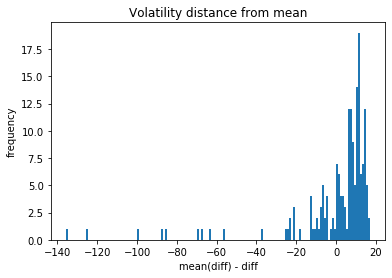

In [13]:
#make a histogram, examine differences. Then examine distance of differences from the mean
plt.hist(no_tweets_final_df['diff'].mean() - no_tweets_final_df['diff'], bins = 153)
plt.title('Volatility distance from mean')
plt.xlabel('mean(diff) - diff')
plt.ylabel('frequency')
print(stats.describe(no_tweets_final_df['diff']))
print(stats.shapiro(no_tweets_final_df['diff']))

It is immediately clear that this the differences are not normally distributed. Visually, there are clear outliers, and the peak is far too tall to be normal. Descriptive statistics confirm this with a ***skewness of 3.46*** and a ***kurtosis of 13.4***. Shapiro gives a p-value of 2x10^-20. 

In [14]:
tweets_final_df = pd.merge(market_tweets, no_tweets_final_df, how='outer', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
tweets_final_df = tweets_final_df.iloc[:, [0,2,3,5,7]]
tweets_final_df = tweets_final_df.groupby('date').mean()

DescribeResult(nobs=979, minmax=(3.7899999999999636, 218.96000000000004), mean=30.430561797752812, variance=730.592811238253, skewness=2.5559454182609325, kurtosis=8.916038338371008)
(0.5782391428947449, 2.314457816271907e-20)


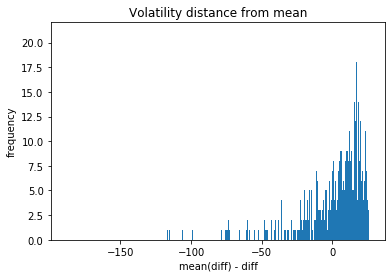

In [15]:
plt.hist(tweets_final_df['diff'].mean() - tweets_final_df['diff'], bins = 700)
plt.title('Volatility distance from mean')
plt.xlabel('mean(diff) - diff')
plt.ylabel('frequency')
print(stats.describe(tweets_final_df['diff']))
print(stats.shapiro(no_tweets_final_df['diff']))

# Results

In [16]:
stats.kruskal(tweets_final_df['diff'].sample(n= 173), no_tweets_final_df['diff'])

KruskalResult(statistic=34.333262540600956, pvalue=4.643768562686048e-09)

Kruskal's test gives us a ***statistic of 30.18*** and a ***p-value of 3.94x10^-8***. We reject the null-hypothesis that the mean volatiltities are equal.

# Implications

Donald Trump's tweets had a statistically significant effect on market volatility. The "real-world" implications of this are numerous. Here's a list of some of the more obvious ones:  
>1. Government officials can move markets with their own personal Twitter accounts. 
>2. There is a means of profiting off of this movement. 
>3. There is a possible means of market manipulation, assuming one could get the market-moving official to collude.
>4. The country may need to have an honest discussion on restricting the social media accounts of high-ranking government officials.
>5. The Efficient Markets Hypothesis may need to be revised. 

# Further Considerations

Things beyond our scope, but hope to examine:
>1. Did the content of tweets matter? Were tweets in which Donald Trump called Nancy Pelosi a Marxist as market-moving as the ones about unemployment and stimulus checks?
>2. Has this set a new precedent? Will future Presidents also have the same power? 
>3. Did Barack Obama's tweets under the official White House twitter have any effect?
>4. Did the official White House twitter during Trump have an effect?
>5. What trading strategy would optimally profit from this phenomenae? 
>6. To what extent could one profit?
>7. Did time of day of the tweets matter?
>8. What about inter-day volatilty instead of intra-day? 
>9. What about foreign markets? Did Mr. Trump move the Nikkei? FTSE 100?
>10. Was the global pandemic partly responsible? Is there a difference in volatility pre-COVID? Is there a difference in the President's effect pre-COVID?

# Potential Shortcomings

This study is rudimentary and incomplete. There are many points from which bias could skew results. Pitfalls: 
>1. n = 173. The actual total days Trump did not tweet was only 58. 
>2. Other non-parametric tests could've been utilized. The distributions for diff look log-normal.
>3. Kruskal-Wallis does not readily provide an effect-size. 

In [17]:
stats.kruskal(tweets_final_df['diff'].sample(n= 173), tweets_final_df['diff'].sample(n= 173))

KruskalResult(statistic=0.01636272718962057, pvalue=0.8982147555716294)

In [18]:
stats.kruskal(no_tweets_final_df['diff'], no_tweets_final_df['diff'])

KruskalResult(statistic=0.0, pvalue=1.0)

A/A test comes back as not statistically significant.